# Quantus + NLP
[![Binder](https://mybinder.org/badge_logo.svg)](https://mybinder.org/v2/gh/understandable-machine-intelligence-lab/Quantus/main?labpath=tutorials%2FTutorial_NLP_Demonstration.ipynb)


This tutorial demonstrates how to use the library for evaluation explanation of text classification models.
For this purpose, we use a pre-trained `Distilbert` model from [Huggingface](https://huggingface.co/models) hub and `GLUE/SST2` dataset [here](https://huggingface.co/datasets/sst2).

Author: Artem Sereda

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/drive/1eWK9ebfMUVRG4mrOAQvXdJ452SMLfffv?usp=sharing)

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import pandas as pd
from datasets import load_dataset
import tensorflow as tf
import logging
from IPython.core.display import HTML
import random
# import matplotx
import matplotlib.pyplot as plt
import gc
from quantus.helpers.plotting import plot_model_parameter_randomisation_experiment
from quantus.nlp.helpers.utils import map_explanations, get_logits_for_labels
import quantus.nlp as qn


# plt.style.use(matplotx.styles.dracula)
logging.getLogger("absl").setLevel(logging.WARNING)
random.seed(42)
tf.config.list_physical_devices()

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
 PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

## 1) Preliminaries

### 1.1 Load pre-trained model and tokenizer from [huggingface](https://huggingface.co/models) hub

In [3]:
model = qn.TensorFlowHuggingFaceTextClassifier.from_pretrained(
    "distilbert-base-uncased-finetuned-sst-2-english"
)

Metal device set to: Apple M1 Pro


2023-03-05 17:57:07.297007: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-03-05 17:57:07.297033: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)
All model checkpoint layers were used when initializing TFDistilBertForSequenceClassification.

All the layers of TFDistilBertForSequenceClassification were initialized from the model checkpoint at distilbert-base-uncased-finetuned-sst-2-english.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFDistilBertForSequenceClassification for predictions without further training.


### 1.2 Load test split of [GLUE/SST2](https://huggingface.co/datasets/sst2) dataset

In [4]:
BATCH_SIZE = 32

dataset = load_dataset("sst2")["test"]
x_batch = dataset["sentence"][:BATCH_SIZE]
random.shuffle(x_batch)

Found cached dataset sst2 (/Users/artemsereda/.cache/huggingface/datasets/sst2/default/2.0.0/9896208a8d85db057ac50c72282bcb8fe755accc671a57dd8059d4e130961ed5)


  0%|          | 0/3 [00:00<?, ?it/s]

Run an example inference, and demonstrate models predictions.

In [6]:
def decode_labels(y_batch: np.ndarray):
    """A helper function to map integer labels to human-readable class names."""
    return [model.unwrap().config.id2label[i] for i in y_batch]


y_batch = model.predict(x_batch).argmax(axis=-1)

# Show the x, y data.
pd.DataFrame([x_batch[:10], decode_labels(y_batch[:10])]).T

,0,1
0,this is junk food cinema at its greasiest .,NEGATIVE
1,uneasy mishmash of styles and genres .,NEGATIVE
2,it 's just incredibly dull .,NEGATIVE
3,a feel-good picture in the best sense of the t...,POSITIVE
4,here 's a british flick gleefully unconcerned ...,POSITIVE
5,a well-made and often lovely depiction of the ...,POSITIVE
6,good movie .,POSITIVE
7,the best way to hope for any chance of enjoyin...,NEGATIVE
8,"some , like ballistic , arrive stillborn ... l...",NEGATIVE
9,reinforces the talents of screenwriter charlie...,POSITIVE


### 1.5 Visualise the explanations.

In [7]:
labels = list(map(lambda i: "Predicted label: " + i, decode_labels(y_batch)))

2023-03-05 17:57:59.112630: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


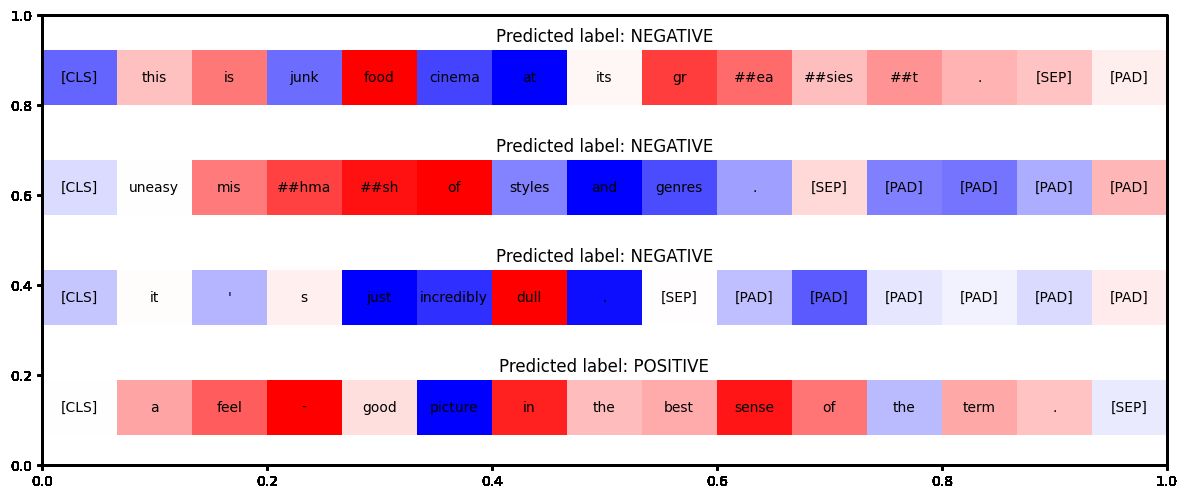

In [8]:
# Visualise Integrated Gradients explanations.
a_batch_int_grad = map_explanations(
    qn.explain(model, x_batch[:4], y_batch[:4], method="IntGrad"),
    qn.normalize_sum_to_1,
)


qn.visualise_explanations_as_pyplot(a_batch_int_grad, labels=labels)

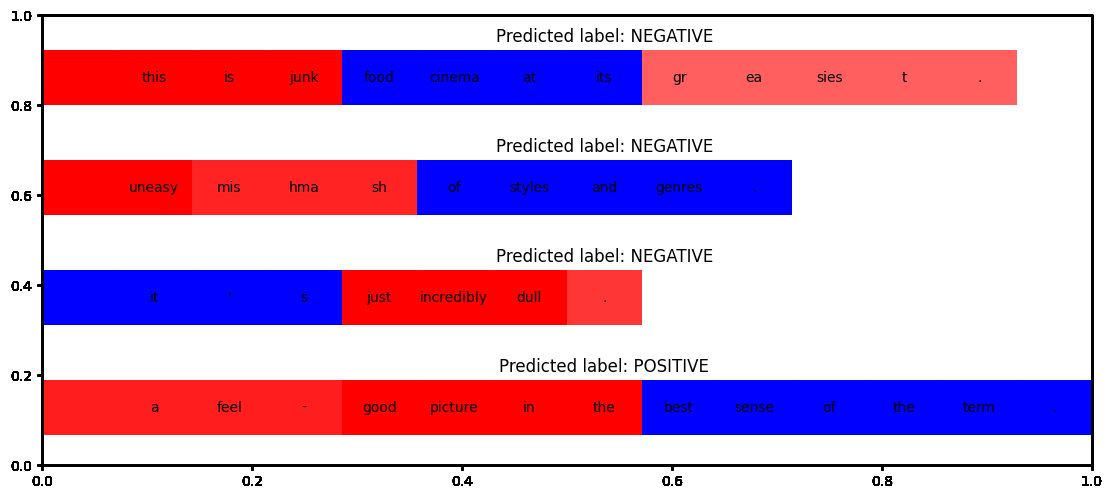

In [9]:
# Visualise SHAP explanations.
a_batch_shap = map_explanations(
    qn.explain(model, x_batch[:4], y_batch[:4], method="SHAP", call_kwargs={"max_evals": 10}),
    qn.normalize_sum_to_1,
)
qn.visualise_explanations_as_pyplot(a_batch_shap, labels=labels)

## 2) Quantitative analysis using Quantus.
To see all available metric and their category, we can run `quantus.nlp.available_metrics()`

In [10]:
qn.available_metrics()

{'Robustness': ['Max-Sensitivity',
  'Avg-Sensitivity',
  'Relative Input Stability',
  'Relative Output Stability',
  'Relative Representation Stability'],
 'Randomisation': ['Model Parameter Randomisation', 'Random Logit'],
 'Faithfulness': ['Token Flipping']}

In [12]:
# We will need it later
# fmt: off
unk_token_embedding = model.embedding_lookup([model.unwrap_tokenizer().unk_token_id])[0, 0]  # noqa
# fmt: on

metrics = {
    # By default, perturbation is applied to plain-text inputs.
    "Average Sensitivity": qn.AvgSensitivity(nr_samples=10, disable_warnings=True),
    "Max Sensitivity": qn.MaxSensitivity(
        nr_samples=10,
        # Perturbation type is inferred from perturb_func signature.
        perturb_func=qn.gaussian_noise,
        disable_warnings=True,
    ),
    "Relative Input Stability": qn.RelativeInputStability(
        nr_samples=10,
        disable_warnings=True,
    ),
    "Relative Output Stability": qn.RelativeOutputStability(
        nr_samples=10,
        disable_warnings=True,
    ),
    "Relative Representation Stability": qn.RelativeRepresentationStability(
        nr_samples=10,
        disable_warnings=True,
    ),
    "Model Parameter Randomisation": qn.ModelParameterRandomisation(
        seed=42,
        disable_warnings=True,
    ),
    # "Random Logit": qn.RandomLogit(num_classes=2, seed=42, disable_warnings=True),
    "Token Flipping": qn.TokenFlipping(disable_warnings=True, abs=True),
}

# By default, qn.explain is used to generate explanations.
call_kwargs = {
    # We use GradXInput as default method for all methods.
    "explain_func_kwargs": {"method": "GradXInput"},
    # We evaluate Relative Input Stability for IntGrad with different baselines.
    "Relative Input Stability": [
        {
            "explain_func_kwargs": {
                "method": "IntGrad",
            }
        },
        {
            "explain_func_kwargs": {
                "method": "IntGrad",
                "baseline_fn": tf.function(lambda x: unk_token_embedding),
            }
        },
    ],
}

# Notice, that no y_batch is required and explain_func_kwargs are passed only to metrics' __call__ method.
result = qn.evaluate(metrics, model, x_batch, call_kwargs=call_kwargs, run_gc=False)
gc.collect()

Evaluation...:   0%|          | 0/7 [00:00<?, ?it/s]

2023-03-05 17:58:33.569830: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
The settings for perturbing input e.g., 'perturb_func' didn't cause change in input. Reconsider the parameter settings.
2023-03-05 17:58:41.410521: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-03-05 17:58:49.032295: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-03-05 17:59:17.976911: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-03-05 17:59:47.740268: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
Some layers from the model checkpoint at distilbert-base-uncased-finetuned-sst-2-english were not used wh

26621

### 2.2 Results visualisation

For pruning task (default one) the tokens are removed in order of increasing relevance scores.
We expect Mean Squared Error to increase as we remove more important ones, 
which acts as a proof that higher scores are assigned to important features.

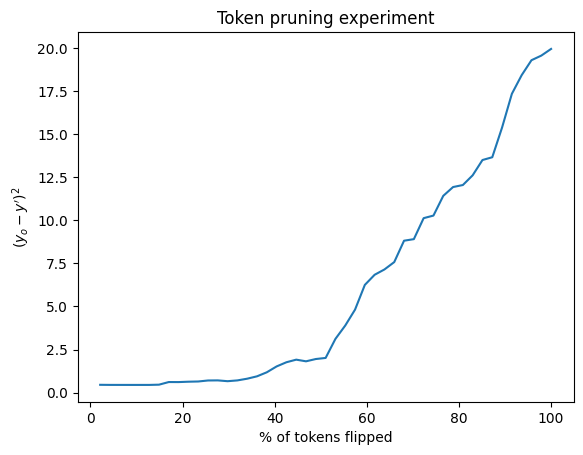

In [13]:
qn.plot_token_flipping_experiment(
    result["Token Flipping"],
    get_logits_for_labels(model.predict(x_batch), y_batch),
    task="pruning"
)
plt.show()

Model Parameter Randomisation shows us how layers' weights correlate with explanations.
0 - means randomizing layers weights changes explanation completely
1 - means randomizing layers weighs did not change explanation at all.

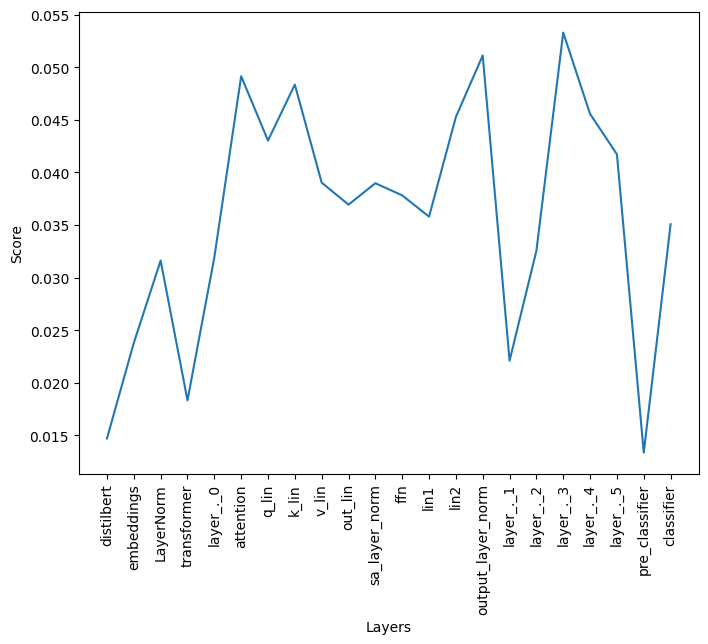

In [14]:
mpr = result["Model Parameter Randomisation"]
plot_model_parameter_randomisation_experiment(mpr)

Robustness metrics show us how sensitive are explanations to slight perturbations.
For this category it is impossible to give general advice. Typically,
- Higher values could mean explanations take more inputs into account, than model
- Lower values could mean explanations are highly biased against certain features from input space (tokens).

Text(0.5, 1.0, 'Sensitivity metrics comparison')

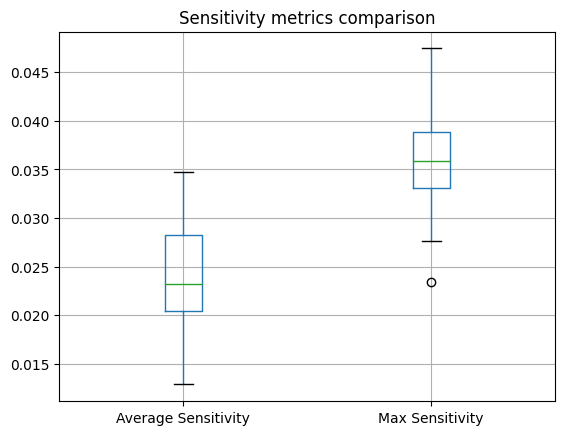

In [15]:
pd.DataFrame.from_dict(
    {
        k: v
        for k, v in result.items()
        if k
        in (
            "Average Sensitivity",
            "Max Sensitivity",
        )
    }
).boxplot()
# plt.yscale("log")
plt.title("Sensitivity metrics comparison")

Text(0.5, 1.0, 'Relative Stability metrics comparison')

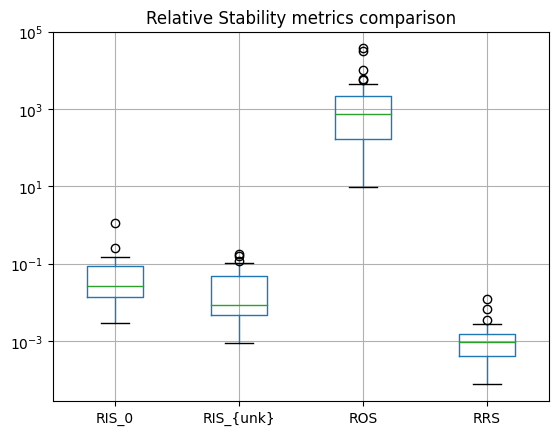

In [16]:
rs = {
    "RIS_0": result["Relative Input Stability"][0],
    "RIS_{unk}": result["Relative Input Stability"][1],
    "ROS": result["Relative Output Stability"],
    "RRS": result["Relative Representation Stability"]
}

pd.DataFrame.from_dict(rs).boxplot()
plt.yscale("log")
plt.title("Relative Stability metrics comparison")